In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from src.models.astromer_1 import restore_model, predict
from sklearn.metrics import r2_score, mean_squared_error
from src.training.utils import train
from src.utils import get_metrics
from matplotlib import gridspec
from src.data import load_data


os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2


2023-10-19 18:41:46.737879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [6]:
folder = './presentation/experiments/astromer_1/results/vh_first_20/2023-10-17_19-25-34/'
exp_folders = glob.glob(os.path.join(folder, 'pretraining'))
exp_folders

['./presentation/experiments/astromer_1/results/vh_first_20/2023-10-17_19-25-34/pretraining']

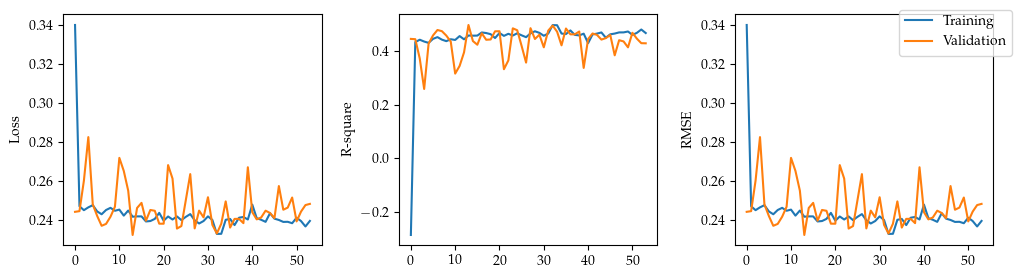

In [9]:
metric_names= ['loss', 'r_square', 'rmse']
format_metric_name = {
    'loss':'Loss',
    'r_square': 'R-square',
    'rmse': 'RMSE',
}

rows = []
fig, axes = plt.subplots(1, 3, figsize=(12, 3), 
                         gridspec_kw={'hspace': 0., 'wspace': 0.3}, sharex=True)
axes = axes.flatten()
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'logs')
    with open(config_path, 'r') as f:
        config = toml.load(f)

        val_metrics = get_metrics(os.path.join(log_dir, 'validation'), 
                                  metric_name='loss')
        best_epoch = val_metrics['value'].astype(float).argmin() 


        for index, metric in enumerate(metric_names):
            try:
                train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
                valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)

                axes[index].plot(train_metrics['step'], train_metrics['value'], label='Training')
                axes[index].plot(valid_metrics['step'], valid_metrics['value'], 
                                 label='Validation') 
#                 axes[index].set_yscale('log')
#                 axes[index].set_xscale('log')
                axes[index].set_ylabel(format_metric_name[metric])
                
                config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
                config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)        
            except:
                continue
                
        rows.append(pd.Series(config))
axes[-1].legend(bbox_to_anchor=(1.1, 1.05))
results = pd.concat(rows, axis=1).T

# Reconstruction

In [10]:
config_path = './presentation/experiments/astromer_1/results/vh_first_20/2023-10-17_19-25-34/pretraining/' 

astromer, conf = restore_model(config_path, mask_format='first-r')

2023-10-19 18:54:34.243902: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-19 18:54:34.243956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 3fd24c04f3fd
2023-10-19 18:54:34.243964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 3fd24c04f3fd
2023-10-19 18:54:34.244150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-10-19 18:54:34.244183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2023-10-19 18:54:34.244564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
first
[INFO] LOADING PRETRAINED WEIGHTS


In [11]:
conf['pe_exp']

2

In [12]:
test_loader = load_data(dataset='./data/records/macho/train/', 
                         batch_size= 16, 
                         probed=1.,  
                         random_same=conf['rs'],
                         window_size=conf['window_size'], 
                         off_nsp=True,
                         repeat=1, 
                         sampling=False)

[INFO] Probed: 1.00 Random: 0.20


In [13]:
%%time
y_pred, y_true, mask = predict(astromer, test_loader.take(5))

[INFO] Processing 5 batches
CPU times: user 7.11 s, sys: 5.14 s, total: 12.3 s
Wall time: 1.66 s


Text(0.96, 0.5, 'Predicted Magnitude')

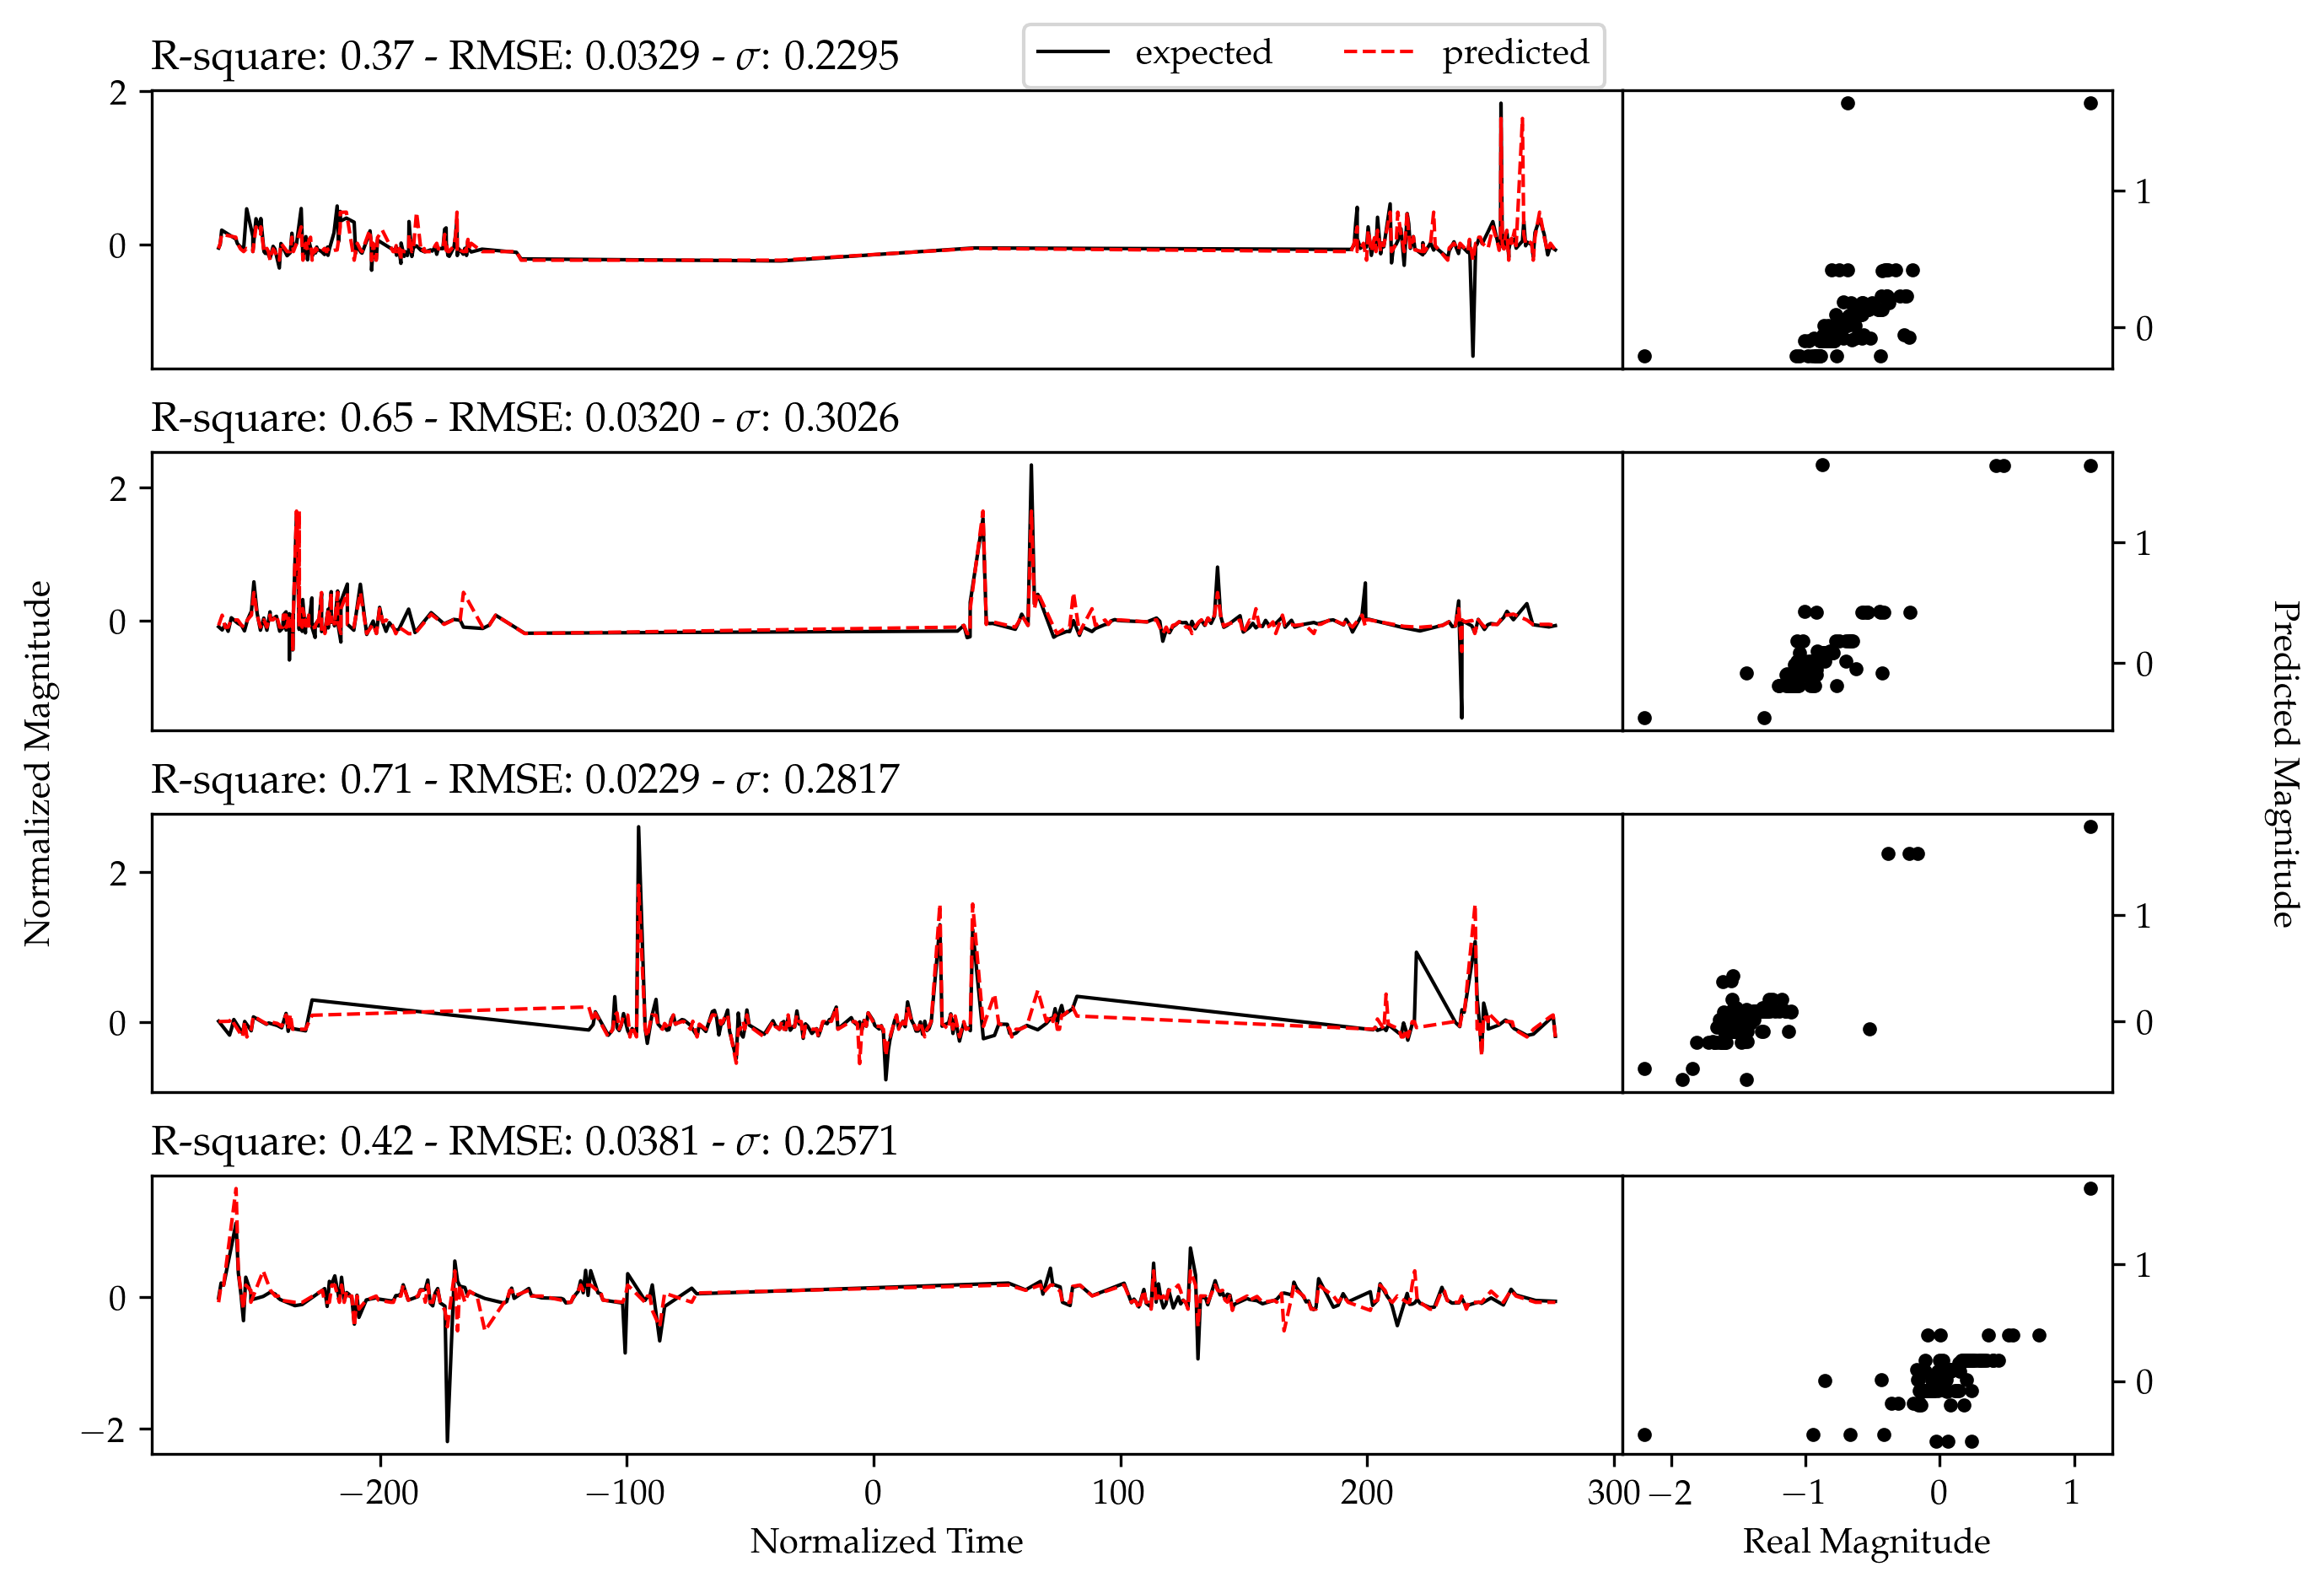

In [14]:
N = 4                  
fig = plt.figure(figsize=(10,7), dpi=300)
gs = gridspec.GridSpec(N, 2, width_ratios=[3, 1]) 
gs.hspace = 0.3
gs.wspace = 0.
plt.subplots_adjust(hspace=0.2, wspace=0.05)

for i, x, y, m in zip(range(N), y_true, y_pred, mask):
    ax0 = plt.subplot(gs[i, 0])
    ax1 = plt.subplot(gs[i, 1])
    
    probed_true  = tf.boolean_mask(x, m[..., 0])
    probed_pred  = tf.boolean_mask(y, m[..., 0])
    
    r2_val   = r2_score(probed_true[:, 1], probed_pred[:, 1])
    rmse_val = mean_squared_error(probed_true[:, 1], probed_pred[:, 1], squared=True)
    
    ax0.plot(probed_true[:, 0], probed_true[:, 1], marker='', linewidth=1, linestyle='-', color='k', label='expected')
    ax0.plot(probed_pred[:, 0], probed_pred[:, 1], marker='', linewidth=1, linestyle='--', color='r', label='predicted')
    ax1.plot(probed_true[:, 1], probed_pred[:, 1], '.', color='k')
    ax0.set_title('R-square: {:.2f} - RMSE: {:.4f} - $\sigma$: {:.4f}'.format(r2_val, 
                                                                          rmse_val, 
                                                                          tf.math.reduce_std(probed_true[:, 1])), loc='left')
    
    if i< N-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax1.set_xticks([])
        
    ax1.yaxis.tick_right() 

    if i ==0:
        ax0.legend(ncol=3,bbox_to_anchor=(1, 1.3))
        
ax0.set_xlabel('Normalized Time')

ax1.set_xlabel('Real Magnitude')
fig.text(0.075, 0.5, 'Normalized Magnitude', va='center', rotation='vertical')
fig.text(0.96, 0.5, 'Predicted Magnitude', va='center', rotation=-90)

# Classification


In [4]:
import tomli
styles = {'MLP+ATT':{'marker':'^', 'linestyle':'-'}, 
          'LSTM+ATT':{'marker':'o', 'linestyle':'--'}, 
          'Baseline':{'marker':'s', 'linestyle':':'}}

ft_names_changed = { 'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'}

ft_datasets = ['alcock']

root_exp = './presentation/experiments/astromer_1/results/v_first/2023-10-14_16-56-26/'

model = 'att_mlp'

In [19]:
metric_paths = glob.glob(os.path.join(root_exp, 
                                       'classification', 
                                       'alcock', 
                                       '*', '*', 
                                       model, 
                                       'metrics.toml'))
config_paths = glob.glob(os.path.join(root_exp, 
                                       'pretraining', 
                                       'config.toml'))

In [51]:
rows = []
for mp in metric_paths:
    fold    = mp.split('/')[-4].split('_')[-1]
    ds_name = mp.split('/')[-3]
    ds, spc = ds_name.split('_')

    with open(mp, "rb") as file:
        toml_data = tomli.load(file)
        toml_data['fold'] = int(fold)
        toml_data['spc'] = int(spc)
        toml_data['ds'] = ds
        rows.append(toml_data)
df = pd.DataFrame(rows)

In [52]:
df['clf_test_f1'] = df['clf_test_f1'].astype(float)
df['clf_test_acc'] = df['clf_test_acc'].astype(float)
df['clf_test_recall'] = df['clf_test_recall'].astype(float)
df['clf_test_precision'] = df['clf_test_precision'].astype(float)

In [53]:
df.groupby(['spc', 'ds']).mean()

,,clf_val_acc,clf_val_loss,clf_test_precision,clf_test_recall,clf_test_f1,clf_test_acc,fold
spc,ds,,,,,,,
20,alcock,0.306725,1.617891,0.245748,0.288208,0.217909,0.326358,1.0
100,alcock,0.282592,1.673160,0.141411,0.219516,0.138238,0.250574,1.0


In [5]:
df = pd.DataFrame(columns=['f1', 'acc', 'model','spc','fold','dataset'])
df_ft = pd.DataFrame(columns=['train_loss', 'train_r_square',  'val_loss', 'val_r_square', 'test_loss', 'test_r_square', 'model','spc','fold','dataset'])
for exp in exp_selected:
    for i in ft_datasets:
        for fold in range(3):
            for size in [20]:
                result_path = os.path.join(root_exp, exp ,i, 'fold_{}'.format(fold), i+'_'+str(size), model,'metrics.toml')
                with open(result_path, "rb") as file:
                    toml_data = tomli.load(file)
                
                data = {'f1':float(toml_data['clf_test_f1']), 'acc': float(toml_data['clf_test_acc']), 
                        'model':model, 'spc':size, 'fold':fold, 'dataset':i, 'exp':exp }
                df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)


FileNotFoundError: [Errno 2] No such file or directory: './presentation/experiments/astromer_1/results/v_first/2023-10-14_16-56-26/2023-10-14_16-56-26/classification/alcock/fold_0/alcock_20/att_mlp/metrics.toml'

Text(0.51, -0.1, 'Samples per class')

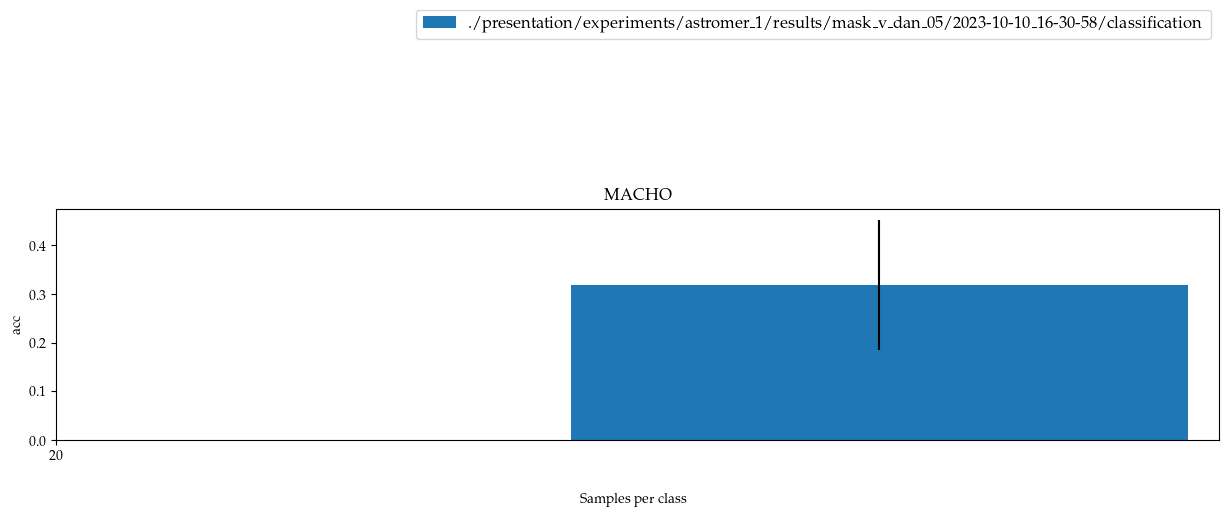

In [10]:
fig, axes = plt.subplots(1, len(ft_datasets), figsize=(15, 3), sharey=False)

if len(ft_datasets) == 1:
    axes = [axes]

for index, ft_dataset in enumerate(ft_datasets):
    deltas = np.linspace(-0.1*len(exp_selected), 0.1,  len(exp_selected))
    for k, exp in enumerate(exp_selected):
        
        downstream_df = df[(df['exp'] == exp) & (df['dataset'] == ft_dataset)]
        downstream_df = downstream_df[downstream_df['model'] == model]
        metric = 'acc' # 'test_f1'
        downstream_df = downstream_df[['spc', 'fold', metric]]
        
        summary = downstream_df.groupby('spc').mean().reset_index()
        summary_std = downstream_df.groupby('spc').std().reset_index()
        
        x_range = np.arange(0, summary['spc'].shape[0], 1) + deltas[k]+0.3
      
           
        axes[index].bar(x_range, summary[metric], yerr=summary_std[metric], width=0.15, label=root_exp+exp)
        axes[index].set_xticks(np.arange(0, summary['spc'].shape[0], 1))
        axes[index].set_xticklabels(summary['spc']) 
        axes[index].set_title(ft_names_changed[ft_dataset])

axes[-1].legend(bbox_to_anchor = (1.,1.9), fontsize=12)
axes[0].set_ylabel(metric)
fig.text(0.51, -0.1, 'Samples per class', ha='center')

In [24]:
exp_selected = ['2023-10-08_20-08-56/finetuning']
df_ft = pd.DataFrame(columns=['train_loss', 'train_r_square',  'val_loss', 'val_r_square', 'test_loss', 'test_r_square','spc','fold','dataset'])
for exp in exp_selected:
    for i in ft_datasets:
        for fold in range(3):
            for size in [20,100,500]:
                result_path = os.path.join(root_exp, exp ,i, 'fold_{}'.format(fold), i+'_'+str(size),'metrics.toml')
                with open(result_path, "rb") as file:
                    toml_data = tomli.load(file)
                
                data = {'train_loss':float(toml_data['train_loss']), 'train_r_square': float(toml_data['train_r_square']),
                        'val_loss':float(toml_data['val_loss']), 'val_r_square': float(toml_data['val_r_square']),
                        'test_loss':float(toml_data['test_loss']), 'test_r_square': float(toml_data['test_r_square']),
                         'spc':size, 'fold':fold, 'dataset':i}
                df_ft = pd.concat([df_ft, pd.DataFrame([data])], ignore_index=True)

In [31]:
ft_dataset = 'atlas'
metric = 'train_loss'
finetuning_df = df_ft[(df_ft['dataset'] == ft_dataset)]
finetuning_df = finetuning_df[['spc', 'fold', 'train_loss', 'val_loss', 'test_loss', 'train_r_square', 'val_r_square', 'test_r_square']]
finetuning_df.groupby('spc').mean().reset_index()

,spc,fold,train_loss,val_loss,test_loss,train_r_square,val_r_square,test_r_square
0,20,1.0,0.056948,0.052634,0.054472,0.639730,0.702676,0.632303
1,100,1.0,0.056297,0.051206,0.053854,0.630053,0.686574,0.633869
2,500,1.0,0.035136,0.050265,0.054523,0.590078,0.653131,0.629175


In [49]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

from tensorboard.backend.event_processing import event_accumulator
from tensorflow.python.lib.io import tf_record
from tensorflow.core.util import event_pb2



def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs, metric_name='epoch_loss', full_logs=True, show_keys=False, nlog=-1):

    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][nlog]
    path_train = os.path.join(path_logs, train_logs)

    if full_logs:
        ea = event_accumulator.EventAccumulator(path_train, 
                                                size_guidance={'tensors': 0})
    else:
        ea = event_accumulator.EventAccumulator(path_train)
      
    ea.Reload()

    if show_keys:
        print(ea.Tags())

    try:
        metrics = pd.DataFrame([(w,s,tf.make_ndarray(t))for w,s,t in ea.Tensors(metric_name)],
                    columns=['wall_time', 'step', 'value'])
    except:
        frames = []
        for file in os.listdir(path_logs):
            if not file.endswith('.csv'): continue
            if metric_name in file:
                metrics = pd.read_csv(os.path.join(path_logs, file))
                metrics.columns = ['wall_time', 'step', 'value']
        
    return metrics



In [50]:
path_logs = './results/mask_v_h_cris_05/2023-10-08_20-08-56/pretraining/logs/test'
get_metrics(path_logs, metric_name='rmse', full_logs=True, show_keys=False, nlog=-1)

,wall_time,step,value
0,1.696931e+09,0,0.046776213
1,1.696931e+09,10000,0.046776213


In [51]:
path_logs = './results/mask_v_h_cris_05/2023-10-08_20-08-56/pretraining/logs/test'
get_metrics(path_logs, metric_name='r_square', full_logs=True, show_keys=False, nlog=-1)

,wall_time,step,value
0,1.696931e+09,0,0.56956136
1,1.696931e+09,10000,0.56956136


In [52]:
path_logs = './results/mask_v_h_cris_05/2023-10-08_20-08-56/pretraining/logs/train'
get_metrics(path_logs, metric_name='rmse', full_logs=True, show_keys=False, nlog=-1)

,wall_time,step,value
0,1.696797e+09,0,0.12935203
1,1.696798e+09,1,0.11077503
2,1.696799e+09,2,0.1059336
3,1.696800e+09,3,0.08512218
4,1.696801e+09,4,0.079741895
...,...,...,...
96,1.696926e+09,96,0.047442343
97,1.696927e+09,97,0.04733091
98,1.696928e+09,98,0.04722757
99,1.696930e+09,99,0.047244996


In [54]:
path_logs = './results/mask_v_h_cris_05/2023-10-08_20-08-56/pretraining/logs/train'
df = get_metrics(path_logs, metric_name='r_square', full_logs=True, show_keys=False, nlog=-1)

In [56]:
max(df.value)

array(0.5703239, dtype=float32)

In [57]:
df

,wall_time,step,value
0,1.696797e+09,0,-0.18171135
1,1.696798e+09,1,-0.013394737
2,1.696799e+09,2,0.031067073
3,1.696800e+09,3,0.22177637
4,1.696801e+09,4,0.2700498
...,...,...,...
96,1.696926e+09,96,0.5663144
97,1.696927e+09,97,0.5672856
98,1.696928e+09,98,0.5678175
99,1.696930e+09,99,0.56816465
